# import package and data

In [3]:
import pandas as pd
import os
import configparser
from neo4j import GraphDatabase
import textwrap
import matplotlib.pyplot as plt

# Set the display format for float values, to avoid using scientific notation for big number
pd.options.display.float_format = '{:.0f}'.format

In [4]:
# Step 1: Load poi_info.csv into DataFrame df_poi_info
poi_info_file = "./raw_data/poi_info.csv"
df_poi_info = pd.read_csv(poi_info_file)

# Display the first few rows of df_poi_info to verify it was loaded correctly
df_poi_info.head()

,id,url,name,type,openingHours,description,duration,price,address,region,avgRating,numReviews,numReviews_5,numReviews_4,numReviews_3,numReviews_2,numReviews_1
0,2149128,https://www.tripadvisor.com/Attraction_Review-...,Gardens by the Bay,"Points of Interest & Landmarks, Gardens",5:00 AM - 2:00 AM,"An integral part of Singapore's ""City in a Gar...",More than 3 hours,8,"18 Marina Gardens Drive Bayfront Plaza, Singap...",Central Area/City Area,4,60393,43439,13817,2541,406,199
1,310900,https://www.tripadvisor.com/Attraction_Review-...,Singapore Botanic Gardens,"Parks, Gardens",5:00 AM - 12:00 AM,This national park is open daily and features ...,1-2 hours,NaN,"1 Cluny Road, Singapore 259 569 Singapore",Tanglin,4,20016,14192,4899,822,66,37
2,4400781,https://www.tripadvisor.com/Attraction_Review-...,Cloud Forest,"Points of Interest & Landmarks, Parks, Gardens",9:00 AM - 9:00 PM,NaN,2-3 hours,11,"18 Marina Gardens Drive, Singapore 018953 Sing...",Central Area/City Area,4,15161,11177,3078,715,138,53
3,324542,https://www.tripadvisor.com/Attraction_Review-...,Singapore Zoo,Zoos,8:30 AM - 6:00 PM,"Set in a rainforest environment, Singapore Zoo...",More than 3 hours,33,"80 Mandai Lake Road, Singapore 729826 Singapore",Central Water Catchment,4,22544,14405,6127,1503,319,190
4,678639,https://www.tripadvisor.com/Attraction_Review-...,Singapore Flyer,"Points of Interest & Landmarks, Observation De...",10:00 AM - 10:00 PM,"At 165 metres tall, Singapore Flyer is a maste...",1-2 hours,NaN,"30 Raffles Avenue, Singapore 039803 Singapore",Marina Centre,4,17410,9284,5753,1960,277,137


In [5]:
# Step 2: Load reviews.csv into DataFrame df_reviews
reviews_file = "./raw_data/reviews.csv"
df_reviews = pd.read_csv(reviews_file)

# Display the first few rows of df_reviews to verify it was loaded correctly
df_reviews.head()

,poiID,username,location,review_id,title,date,rating,user_group,content,review_url
0,2149128,kra63,"Sydney, Australia",735976516,Great potential but experience marred by overc...,"January 1, 2020",5,NaN,We visited during the evening to catch the lig...,https://www.tripadvisor.com/ShowUserReviews-g2...
1,2149128,KLPLeeds,Leeds,752547885,Wow wow wow - MUST DO!!!,"April 12, 2020",5,NaN,This is free and the most amazing thing to do....,https://www.tripadvisor.com/ShowUserReviews-g2...
2,2149128,mhsiong,"Wellington, New Zealand",742358229,Breathtaking views of the city and great lands...,"February 1, 2020",5,NaN,I am not a plant person and I love Gardens by ...,https://www.tripadvisor.com/ShowUserReviews-g2...
3,2149128,PhilthetravellerXI,"Avoca Beach, Australia",753097566,Amazing gardens and landscaping.,"May 2, 2020",5,NaN,This fantastic area is located by the harbour ...,https://www.tripadvisor.com/ShowUserReviews-g2...
4,2149128,G8nzgirl,"Auckland Central, New Zealand",737918097,GARDEN OASIS IN THE CITY,"January 8, 2020",5,NaN,There is no cost to walking around the Gardens...,https://www.tripadvisor.com/ShowUserReviews-g2...


# Prepossessing

## Prepare nodes for neo4j

In [6]:
# Selecting columns for df_node_poi
selected_columns = ['id', 'name', 'description', 'url', 'openingHours', 'duration',
                    'price', 'address', 'avgRating', 'numReviews', 'numReviews_5',
                    'numReviews_4', 'numReviews_3', 'numReviews_2', 'numReviews_1']

# Create df_node_poi from df_poi_info with selected columns
df_node_poi = df_poi_info[selected_columns].copy()

# Display the new DataFrame
print(df_node_poi)

          id                         name  \
0    2149128           Gardens by the Bay   
1     310900    Singapore Botanic Gardens   
2    4400781                 Cloud Forest   
3     324542                Singapore Zoo   
4     678639              Singapore Flyer   
..       ...                          ...   
64  17821111           Low Salt Low Sugar   
65  17738872  Zenith Wholesale Enterprise   
66  26356283            Singapore airport   
67  21353012                 J2 Terrarium   
68  20318911               D'Open Kitchen   

                                          description  \
0   An integral part of Singapore's "City in a Gar...   
1   This national park is open daily and features ...   
2                                                 NaN   
3   Set in a rainforest environment, Singapore Zoo...   
4   At 165 metres tall, Singapore Flyer is a maste...   
..                                                ...   
64  Discover the joys of Peranakan cooking in rich...   
65 

In [7]:
# Create df_node_type with unique values from 'type' column
df_node_category = pd.DataFrame(df_poi_info['type'].str.split(', ').explode().unique(), columns=['name'])

# Drop rows with empty cells
df_node_category.dropna(inplace=True)
# Reindex the dataframe
df_node_category.reset_index(drop=True, inplace=True)

# Add an 'id' column
df_node_category['id'] = range(1, len(df_node_category) + 1)

# Reorder the columns
df_node_category = df_node_category[['id', 'name']]

# Display the DataFrame
print("df_node_category:")
print(df_node_category)

df_node_category:
    id                            name
0    1  Points of Interest & Landmarks
1    2                         Gardens
2    3                           Parks
3    4                            Zoos
4    5      Observation Decks & Towers
5    6    Observatories & Planetariums
6    7                   Neighborhoods
7    8             Monuments & Statues
8    9            Scenic Walking Areas
9   10   Public Transportation Systems
10  11                           Trams
11  12                        Lookouts
12  13                 History Museums
13  14                  Shopping Malls
14  15           Flea & Street Markets
15  16                       Breweries
16  17                 Religious Sites
17  18    Game & Entertainment Centers
18  19                   Biking Trails
19  20         Nature & Wildlife Areas
20  21           Churches & Cathedrals
21  22                  Historic Sites
22  23                         Beaches
23  24                Military Museums
24  25 

In [8]:
# Create df_node_region with unique values from 'region' column
df_node_region = pd.DataFrame(df_poi_info['region'].unique(), columns=['name'])

# Drop rows with empty cells
df_node_region.dropna(inplace=True)
# Reindex the dataframe
df_node_region.reset_index(drop=True, inplace=True)

# Add an 'id' column
df_node_region.insert(0, 'id', df_node_region.index + 1)  # Insert 'id' column as the first column

print("df_node_region:")
print(df_node_region)


df_node_region:
    id                       name
0    1     Central Area/City Area
1    2                    Tanglin
2    3    Central Water Catchment
3    4              Marina Centre
4    5                 Marina Bay
5    6                     Outram
6    7           Mount Faber Park
7    8                Changi West
8    9                  City Hall
9   10  Central Business District
10  11                       Tuas
11  12                     Changi
12  13               Little India
13  14                   Toh Guan
14  15                  Pasir Ris
15  16                  Boulevard
16  17                   Lavender
17  18                   Somerset
18  19                Bukit Batok
19  20              Marine Parade
20  21           Southern Islands
21  22                     Museum
22  23               Geylang East
23  24                Tanjong Rhu
24  25                   Crawford
25  26                     Yishun
26  27         Red Light District
27  28                  Woodland

In [9]:
# Create df_node_user with unique values from 'username' and 'location' columns
df_node_user = df_reviews[['username']].drop_duplicates().reset_index(drop=True)

# Add an 'id' column
df_node_user['id'] = df_node_user.index + 1  # Assign unique IDs starting from 1

# Reorder columns
df_node_user = df_node_user[['id', 'username']]

# Rename columns
df_node_user.columns = ['id', 'name']

print("df_node_user:")
print(df_node_user)

df_node_user:
          id                name
0          1               kra63
1          2            KLPLeeds
2          3             mhsiong
3          4  PhilthetravellerXI
4          5            G8nzgirl
...      ...                 ...
58651  58652             munstar
58652  58653              pt2pt3
58653  58654        bdiddyonfoot
58654  58655       brucesF1784AF
58655  58656           Elise_Toh

[58656 rows x 2 columns]


In [10]:
# Filter out string values from the 'location' column
locations = df_reviews.loc[df_reviews['location'].apply(lambda x: isinstance(x, str)), 'location'].unique()

# Create a DataFrame for Origin node with unique locations
df_node_origin = pd.DataFrame(locations, columns=['name'])

# Add an 'id' column
df_node_origin['id'] = df_node_origin.index + 1  # Assign unique IDs starting from 1

# Reorder columns with 'id' at the left
df_node_origin = df_node_origin[['id', 'name']]

print("df_node_origin:")
print(df_node_origin)


df_node_origin:
        id                           name
0        1              Sydney, Australia
1        2                          Leeds
2        3        Wellington, New Zealand
3        4         Avoca Beach, Australia
4        5  Auckland Central, New Zealand
...    ...                            ...
9398  9399                    Pisa, Italy
9399  9400      Bergdietikon, Switzerland
9400  9401               Songshan, Taipei
9401  9402           Tanah Rata, Malaysia
9402  9403                        Killara

[9403 rows x 2 columns]


In [11]:
# Create df_node_review DataFrame
df_node_review = df_reviews[['review_id', 'title', 'date', 'rating', 'content']].copy()

# Rename 'review_id' column to 'id'
df_node_review.rename(columns={'review_id': 'id'}, inplace=True)

# Convert 'date' column to date format
df_node_review['date'] = pd.to_datetime(df_node_review['date'])

# Find count for each unique value in 'rating'
rating_counts = df_node_review['rating'].value_counts()
print("\nRating Counts:")
print(rating_counts)

# display df
print("df_node_review:")
print(df_node_review)


Rating Counts:
rating
5    84308
3     4846
4     1294
2        7
Name: count, dtype: int64
df_node_review:
              id                                              title  \
0      735976516  Great potential but experience marred by overc...   
1      752547885                           Wow wow wow - MUST DO!!!   
2      742358229  Breathtaking views of the city and great lands...   
3      753097566                   Amazing gardens and landscaping.   
4      737918097                           GARDEN OASIS IN THE CITY   
...          ...                                                ...   
90450  304695886                        Bollywood fix on Orchard Rd   
90451  434953690                      Just good clean entertainment   
90452  712928467  Great Experience, welcoming and knowledgeable ...   
90453  879876989                                            NO SHOW   
90454  711828610                           Peranakan Cooking Lesson   

            date  rating              

# Prepare relationship for neo4j

In [12]:
# Create df_poi_belongsto_category to indicate relationship between POIs and types
# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each row in df_poi_info
for index, row in df_poi_info.iterrows():
    # Check if 'type' column is not empty
    if pd.notna(row['type']):
        # Split the 'type' values
        types = row['type'].split(', ')
        # Create a DataFrame for current row
        df = pd.DataFrame({'poi_id': [row['id']] * len(types), 'category_id': [df_node_category[df_node_category['name'] == t]['id'].iloc[0] for t in types]})
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list
df_poi_belongsto_category = pd.concat(dfs, ignore_index=True)

# Drop rows with empty cells
df_poi_belongsto_category.dropna(inplace=True)
# Reindex the dataframe
df_poi_belongsto_category.reset_index(drop=True, inplace=True)

print("\df_poi_belongsto_category:")
print(df_poi_belongsto_category)

\df_poi_belongsto_category:
      poi_id  category_id
0    2149128            1
1    2149128            2
2     310900            3
3     310900            2
4    4400781            1
..       ...          ...
90  15360350           41
91  17821111           35
92  26356283            2
93  21353012           42
94  20318911           35

[95 rows x 2 columns]


<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
C:\Users\xiong\AppData\Local\Temp\ipykernel_1716\2446306459.py:24: SyntaxWarning: invalid escape sequence '\d'
  print("\df_poi_belongsto_category:")


In [13]:
# Create df_poi_locatedat_region to indicate relationship between POIs and regions
df_poi_locatedat_region = df_poi_info[['id', 'region']].rename(columns={'id': 'poi_id', 'region': 'region_name'})

# Merge df_poi_locatedat_region with df_node_region to get region_id
df_poi_locatedat_region = df_poi_locatedat_region.merge(df_node_region, left_on='region_name', right_on='name', how='left')

# Drop unnecessary columns and rename columns
df_poi_locatedat_region.drop(columns=['region_name', 'name'], inplace=True)
df_poi_locatedat_region.rename(columns={'id': 'region_id'}, inplace=True)

# Drop rows with empty cells
df_poi_locatedat_region.dropna(inplace=True)
# Reindex the dataframe
df_poi_locatedat_region.reset_index(drop=True, inplace=True)

print("\ndf_poi_locatedat_region:")
print(df_poi_locatedat_region)



df_poi_locatedat_region:
      poi_id  region_id
0    2149128          1
1     310900          2
2    4400781          1
3     324542          3
4     678639          4
..       ...        ...
60  15360350         28
61  17821111         29
62  17738872          6
63  21353012         26
64  20318911         10

[65 rows x 2 columns]


In [14]:
# Create df_user_reviewed_poi DataFrame
df_user_reviewed_poi = df_reviews[['review_id', 'username', 'poiID']].copy()

# Merge df_user_reviewed_poi with df_node_user to get user_id
df_user_reviewed_poi = pd.merge(df_user_reviewed_poi, df_node_user[['name', 'id']], how='left', left_on='username', right_on='name')

# Drop the 'name' column
df_user_reviewed_poi.drop(columns=['username', 'name'], inplace=True)

# Rename 'username' column to 'user_id'
df_user_reviewed_poi.rename(columns={'id': 'user_id'}, inplace=True)

# Rename 'poiID' column to 'poi_id'
df_user_reviewed_poi.rename(columns={'poiID': 'poi_id'}, inplace=True)

# Drop rows with empty cells
df_user_reviewed_poi.dropna(inplace=True)
# Reindex the dataframe
df_user_reviewed_poi.reset_index(drop=True, inplace=True)

print("df_user_reviewed_poi:")
print(df_user_reviewed_poi)

df_user_reviewed_poi:
       review_id    poi_id  user_id
0      735976516   2149128        1
1      752547885   2149128        2
2      742358229   2149128        3
3      753097566   2149128        4
4      737918097   2149128        5
...          ...       ...      ...
90450  304695886   7275891    58652
90451  434953690   7275891    58653
90452  712928467  17821111    58654
90453  879876989  17821111    58655
90454  711828610  17821111    58656

[90455 rows x 3 columns]


In [15]:
# Merge df_reviews with df_node_user to get user_id
df_user_from_origin = pd.merge(df_reviews[['username', 'location']], df_node_user[['name', 'id']], how='left', left_on='username', right_on='name')

# Drop the 'name' column
df_user_from_origin.drop(columns=['name', 'username'], inplace=True)

# Rename the 'id' column to 'user_id'
df_user_from_origin.rename(columns={'id': 'user_id'}, inplace=True)

# Merge df_user_from_origin with df_node_origin to get origin_id
df_user_from_origin = pd.merge(df_user_from_origin, df_node_origin, how='left', left_on='location', right_on='name')

# Drop the 'name' column
df_user_from_origin.drop(columns=['name', 'location'], inplace=True)

# Rename the 'id' column to 'origin_id'
df_user_from_origin.rename(columns={'id': 'origin_id'}, inplace=True)

# Drop duplicates from df_user_from_origin
df_user_from_origin.drop_duplicates(inplace=True)
# Drop rows with empty cells
df_user_from_origin.dropna(inplace=True)
# Reindex the dataframe
df_user_from_origin.reset_index(drop=True, inplace=True)

print("df_user_from_origin:")
print(df_user_from_origin)


df_user_from_origin:
       user_id  origin_id
0            1          1
1            2          2
2            3          3
3            4          4
4            5          5
...        ...        ...
51273    58650         54
51274    58651        258
51275    58652       6405
51276    58653       5553
51277    58654        102

[51278 rows x 2 columns]


# exploratory data analysis (EDA)

In [7]:
# Basic Stat: examining the structure and summary statistics of the df_poi_info dataframe.

# Displaying the structure of df_poi_info
print("Shape of df_poi_info:", df_poi_info.shape)
print("\nColumns of df_poi_info:", df_poi_info.columns)

# Displaying summary statistics
print("\nSummary Statistics of Numeric Columns:")
print(df_poi_info.describe())

# Displaying the first few rows of df_poi_info
print("\nFirst few rows of df_poi_info:")
print(df_poi_info.head())


Shape of df_poi_info: (69, 17)

Columns of df_poi_info: Index(['id', 'url', 'name', 'type', 'openingHours', 'description', 'duration',
       'price', 'address', 'region', 'avgRating', 'numReviews', 'numReviews_5',
       'numReviews_4', 'numReviews_3', 'numReviews_2', 'numReviews_1'],
      dtype='object')

Summary Statistics of Numeric Columns:
            id  price  avgRating  numReviews  numReviews_5  numReviews_4  \
count       69     12         66          69            69            69   
mean   7727541     18          4        3406          2172           924   
std    8336349      7          0        9065          6347          2242   
min     310895      8          2           0             0             0   
25%     591532     12          4          45            19            13   
50%    2344513     19          4         125            47            49   
75%   14904083     22          4         742           462           347   
max   26356283     33          5       6039

explore the structure and summary statistics of the df_reviews dataframe.

In [8]:
# Basic Stat: 

# Displaying the structure of df_reviews
print("Shape of df_reviews:", df_reviews.shape)
print("\nColumns of df_reviews:", df_reviews.columns)

# Displaying summary statistics
print("\nSummary Statistics of Numeric Columns:")
print(df_reviews.describe())

# Displaying the first few rows of df_reviews
print("\nFirst few rows of df_reviews:")
print(df_reviews.head())


Shape of df_reviews: (90455, 10)

Columns of df_reviews: Index(['poiID', 'username', 'location', 'review_id', 'title', 'date', 'rating',
       'user_group', 'content', 'review_url'],
      dtype='object')

Summary Statistics of Numeric Columns:
         poiID  review_id  rating
count    90455      90455   90455
mean   3334376  460764124       5
std    3311750  174654485       0
min     310895   91762688       2
25%     324543  332157208       5
50%    2149128  459525738       5
75%    8016698  589788580       5
max   25547486  938502324       5

First few rows of df_reviews:
     poiID            username                       location  review_id  \
0  2149128               kra63              Sydney, Australia  735976516   
1  2149128            KLPLeeds                          Leeds  752547885   
2  2149128             mhsiong        Wellington, New Zealand  742358229   
3  2149128  PhilthetravellerXI         Avoca Beach, Australia  753097566   
4  2149128            G8nzgirl  Auckl

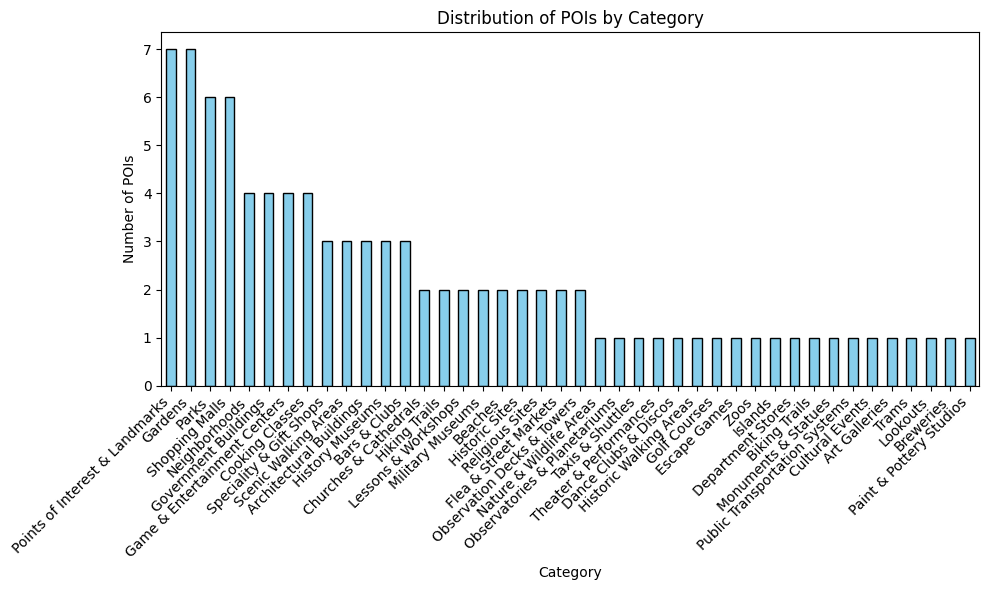

In [17]:
# Distribution of POIs by Category

# Merge df_poi_belongsto_category with df_node_category to get category names
poi_category_names = df_poi_belongsto_category.merge(df_node_category, left_on='category_id', right_on='id', how='left')

# Calculate the number of POIs by category name
attraction_counts = poi_category_names['name'].value_counts()

# Plot the distribution of POIs by category name
plt.figure(figsize=(10, 6))
attraction_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Category')
plt.ylabel('Number of POIs')
plt.title('Distribution of POIs by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


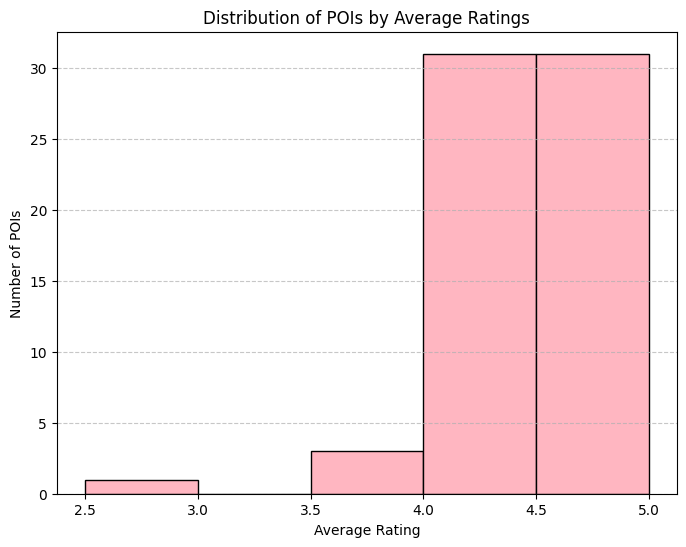

In [86]:
# Distribution of POIs by Average Ratings

plt.figure(figsize=(8, 6))
df_poi_info['avgRating'].plot(kind='hist', bins=5, color='lightpink', edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Number of POIs')
plt.title('Distribution of POIs by Average Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


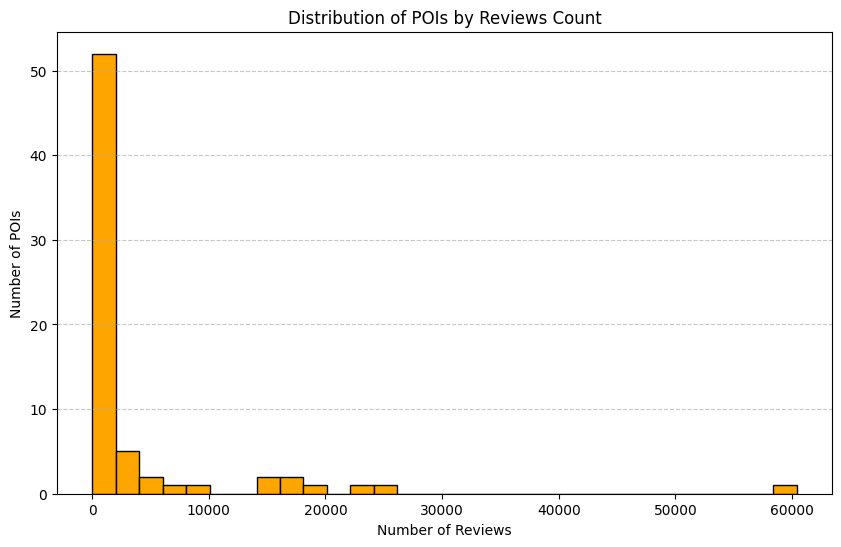

In [21]:
# Distribution of POIs by Reviews Count

plt.figure(figsize=(10, 6))
df_poi_info['numReviews'].plot(kind='hist', bins=30, color='orange', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of POIs')
plt.title('Distribution of POIs by Reviews Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

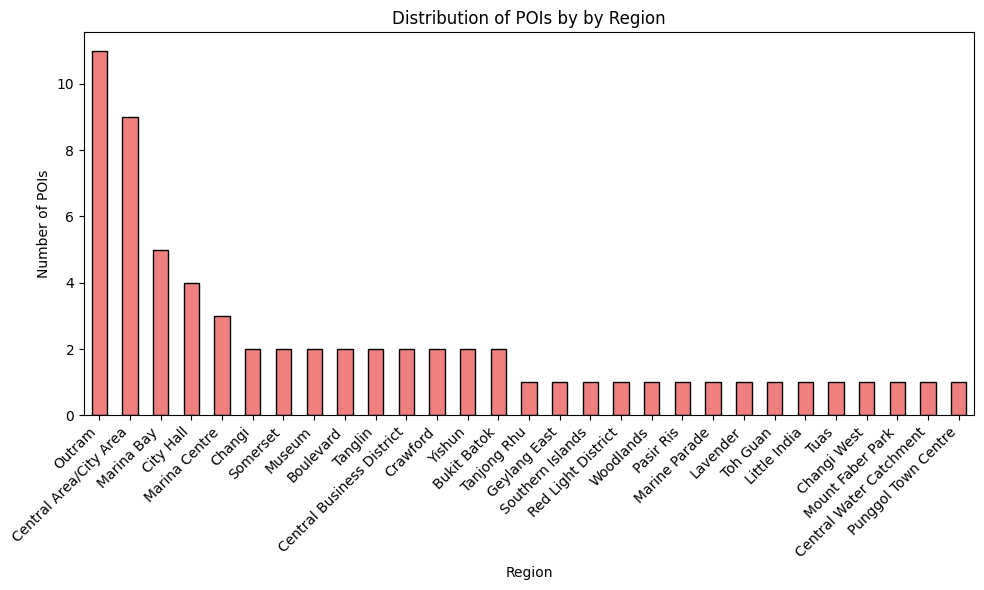

In [73]:
# Distribution of POIs by by Region

region_counts = df_poi_info['region'].value_counts()
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel('Region')
plt.ylabel('Number of POIs')
plt.title('Distribution of POIs by by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

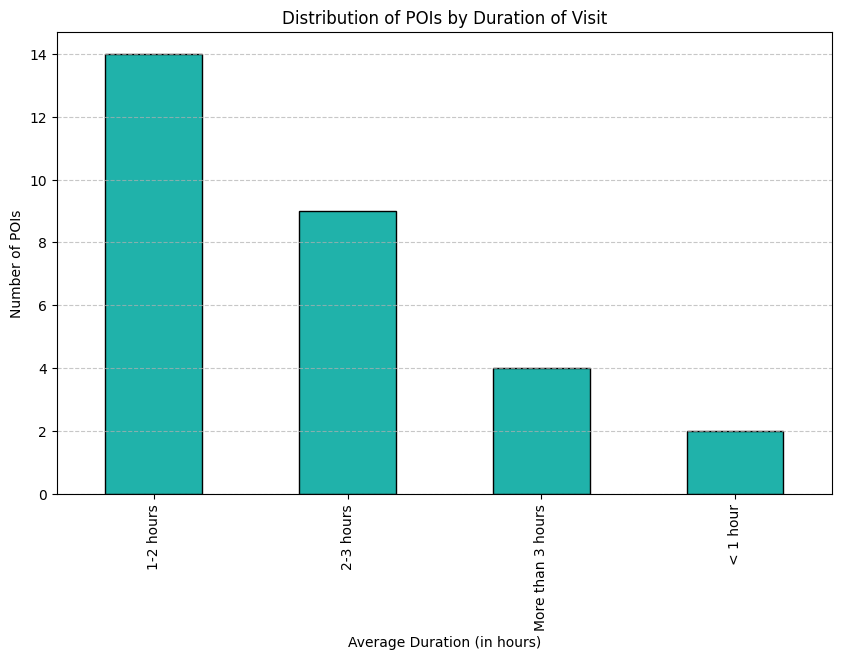

In [22]:
# Distribution of POIs by Duration of Visit

duration_counts = df_node_poi['duration'].value_counts()
plt.figure(figsize=(10, 6))
duration_counts.plot(kind='bar', color='lightseagreen', edgecolor='black')

plt.xlabel('Average Duration (in hours)')
plt.ylabel('Number of POIs')
plt.title('Distribution of POIs by Duration of Visit')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

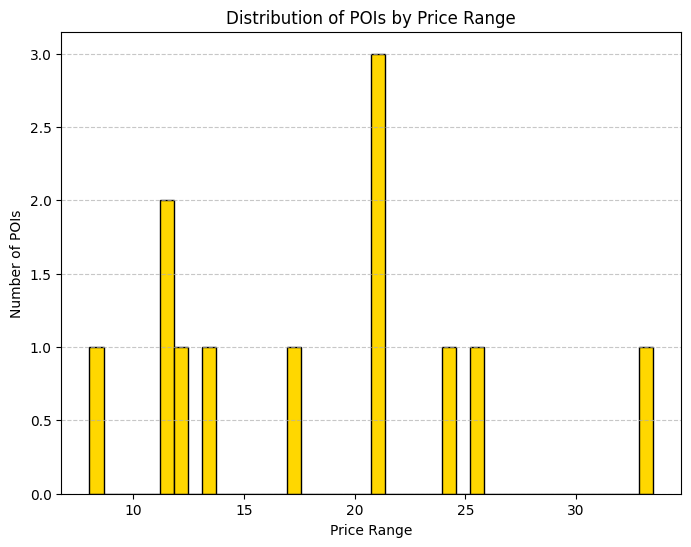

In [23]:
# Distribution of POIs by Price Range
plt.figure(figsize=(8, 6))
df_node_poi['price'].plot(kind='hist', bins=40, color='gold', edgecolor='black')
plt.xlabel('Price Range')
plt.ylabel('Number of POIs')
plt.title('Distribution of POIs by Price Range')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

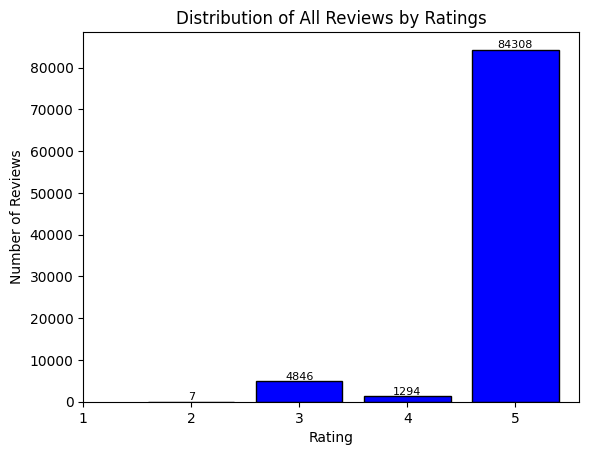

In [80]:
# Distribution of All Reviews by Ratings

# Count the occurrences of each rating
rating_counts = df_reviews['rating'].value_counts().sort_index()

# Plot the distribution of ratings
plt.bar(rating_counts.index, rating_counts.values, color='blue', edgecolor='black')

# Set x-axis ticks to only display 1, 2, 3, 4, 5
plt.xticks(range(1, 6))

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of All Reviews by Ratings')

# Add text labels on top of each bar
for i, count in enumerate(rating_counts.values):
    plt.text(rating_counts.index[i], count, str(count), ha='center', va='bottom', fontsize=8)

# Show plot
plt.show()

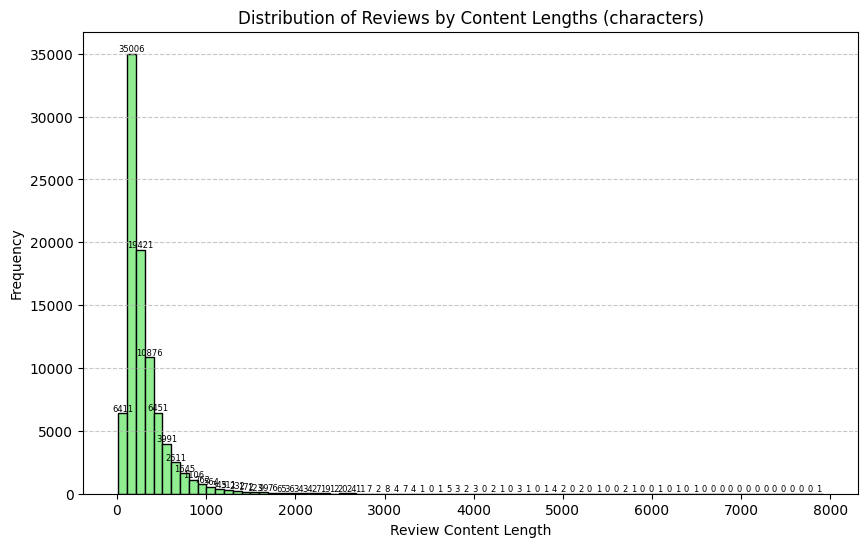

In [85]:
# Distribution of Reviews by Content Lengths (characters)

# Calculate the length of each review
df_reviews['review_length'] = df_reviews['content'].apply(lambda x: len(str(x)))

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(df_reviews['review_length'], bins=80, color='lightgreen', edgecolor='black')
plt.xlabel('Review Content Length')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews by Content Lengths (characters)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add number above each bar
for count, bin_edge in zip(counts, bins):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=6)

plt.show()

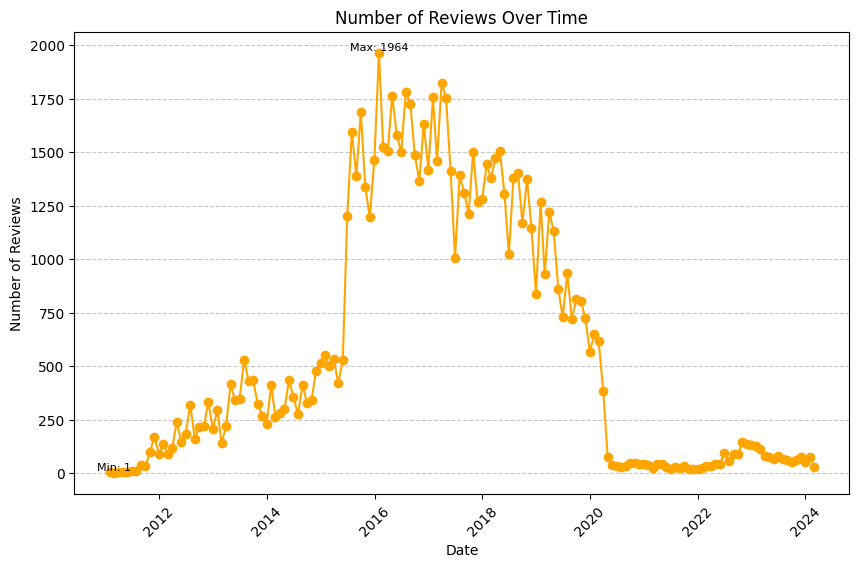

In [87]:
# Temporal Analysis of Reviews

# Convert 'date' column to datetime format
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

# Plot the number of reviews over time
plt.figure(figsize=(10, 6))
reviews_over_time = df_reviews.groupby(pd.Grouper(key='date', freq='M')).size().reset_index(name='num_reviews')
plt.plot(reviews_over_time['date'], reviews_over_time['num_reviews'], marker='o', color='orange')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Over Time')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add maximum and minimum points
max_point = reviews_over_time.loc[reviews_over_time['num_reviews'].idxmax()]
min_point = reviews_over_time.loc[reviews_over_time['num_reviews'].idxmin()]
plt.text(max_point['date'], max_point['num_reviews'], f"Max: {max_point['num_reviews']}", ha='center', va='bottom', fontsize=8)
plt.text(min_point['date'], min_point['num_reviews'], f"Min: {min_point['num_reviews']}", ha='center', va='bottom', fontsize=8)

plt.show()


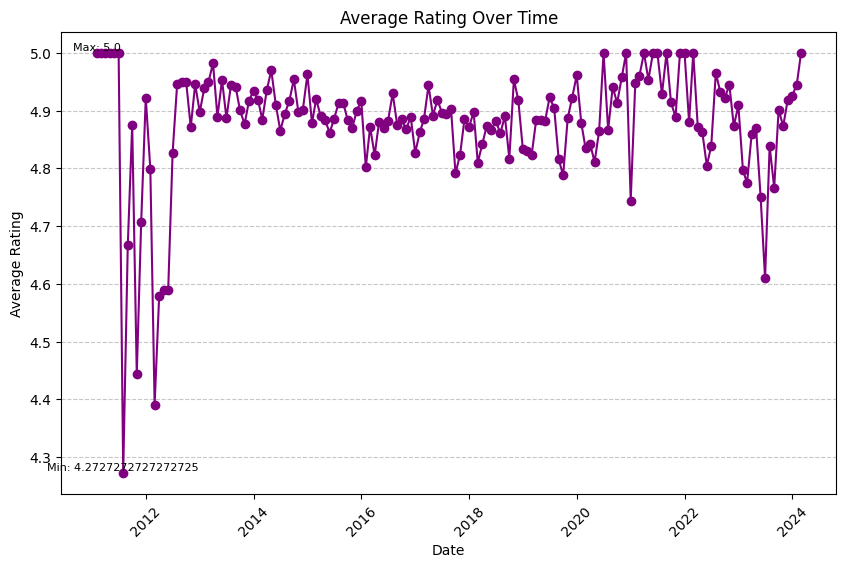

In [88]:
# Average Rating Trends Over Time

# Convert 'date' column to datetime format
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

# Calculate the average rating by month
average_rating_over_time = df_reviews.groupby(pd.Grouper(key='date', freq='M'))['rating'].mean().reset_index()

# Plot the average rating over time
plt.figure(figsize=(10, 6))
plt.plot(average_rating_over_time['date'], average_rating_over_time['rating'], marker='o', color='purple')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add maximum and minimum points
max_point = average_rating_over_time.loc[average_rating_over_time['rating'].idxmax()]
min_point = average_rating_over_time.loc[average_rating_over_time['rating'].idxmin()]
plt.text(max_point['date'], max_point['rating'], f"Max: {max_point['rating']}", ha='center', va='bottom', fontsize=8)
plt.text(min_point['date'], min_point['rating'], f"Min: {min_point['rating']}", ha='center', va='bottom', fontsize=8)

plt.show()

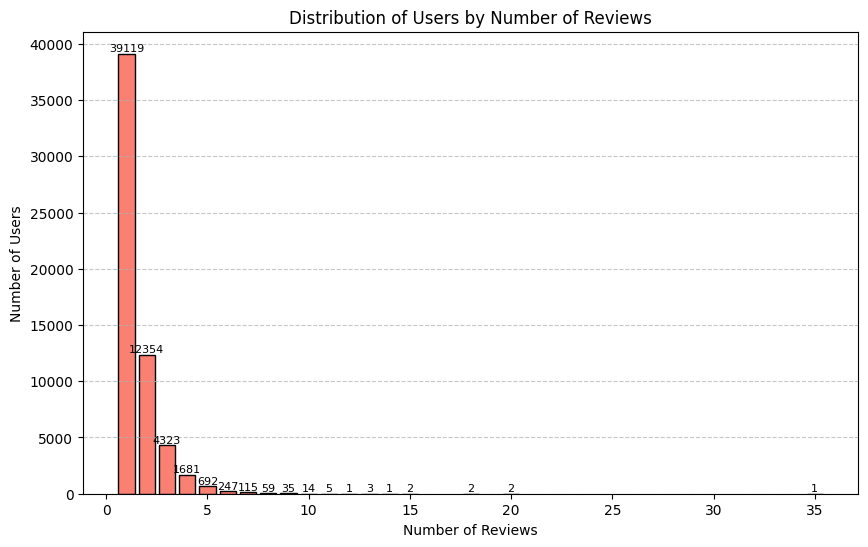

In [4]:
# Distribution of Users by Number of Reviews

# Group reviews by user and count the number of reviews per user
user_review_counts = df_reviews.groupby('username').size().reset_index(name='review_count')

# Calculate the frequency of users by number of reviews
user_review_frequency = user_review_counts['review_count'].value_counts().reset_index()
user_review_frequency.columns = ['Number of Reviews', 'Frequency']

# Sort the dataframe by the number of reviews
user_review_frequency = user_review_frequency.sort_values(by='Number of Reviews')

# Plot the distribution of users by number of reviews
plt.figure(figsize=(10, 6))
bars = plt.bar(user_review_frequency['Number of Reviews'], user_review_frequency['Frequency'], color='salmon', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=8)

plt.show()

In [ ]:
'''
#some color options to differentiate between graphs:

lightblue
salmon
lightgreen
gold
lightcoral
lightskyblue
lightseagreen
lightpink
lightsteelblue
lightgray
'''

# Export processed data to .csv file

In [20]:
# Directory to save CSV files
directory = 'neo4j_import'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save df_node_poi
df_node_poi.to_csv(os.path.join(directory, 'df_node_poi.csv'), index=False)

# Save df_node_category
df_node_category.to_csv(os.path.join(directory, 'df_node_category.csv'), index=False)

# Save df_node_region
df_node_region.to_csv(os.path.join(directory, 'df_node_region.csv'), index=False)

# Save df_node_user
df_node_user.to_csv(os.path.join(directory, 'df_node_user.csv'), index=False)

# Save df_node_origin
df_node_origin.to_csv(os.path.join(directory, 'df_node_origin.csv'), index=False)


# Save df_node_review
#df_node_review.to_csv(os.path.join(directory, 'df_node_review.csv'), index=False)

# Split the DataFrame into two halves
half_len = len(df_node_review) // 2
df_node_review_1 = df_node_review.iloc[:half_len]
df_node_review_2 = df_node_review.iloc[half_len:]

# Save each half to separate CSV files
df_node_review_1.to_csv(os.path.join(directory, 'df_node_review_1.csv'), index=False)
df_node_review_2.to_csv(os.path.join(directory, 'df_node_review_2.csv'), index=False)


# Save df_poi_belongsto_category
df_poi_belongsto_category.to_csv(os.path.join(directory, 'df_poi_belongsto_category.csv'), index=False)

# Save df_poi_locatedat_region
df_poi_locatedat_region.to_csv(os.path.join(directory, 'df_poi_locatedat_region.csv'), index=False)

# Save df_user_reviewed_poi
df_user_reviewed_poi.to_csv(os.path.join(directory, 'df_user_reviewed_poi.csv'), index=False)

# Save df_user_from_origin
df_user_from_origin.to_csv(os.path.join(directory, 'df_user_from_origin.csv'), index=False)
